In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

## Import Statements

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
sys.path.insert(0, r'G:\My Drive\DNN')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
 
# from utils.helper import fn_plot_decision_boundary # this function is from helper.py

In [3]:
# print (fn_plot_decision_boundary.__doc__)

## Setup Global Parameters

In [4]:
###----------------
### Some parameters
###----------------

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 200  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Generate Data Set
<div style="font-family: Arial; font-size:1.2em;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [5]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0], dtype=int64))

## Visualization
<p style="font-family: Arial; font-size:1.2em">
DataFrames are easier to visualize
</p>

In [6]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])

data_df['target'] = y

data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [8]:
data_df.describe() # Generate descriptive statistic

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


In [9]:
# what labels are present?
data_df.target.unique()

array([0, 1], dtype=int64)

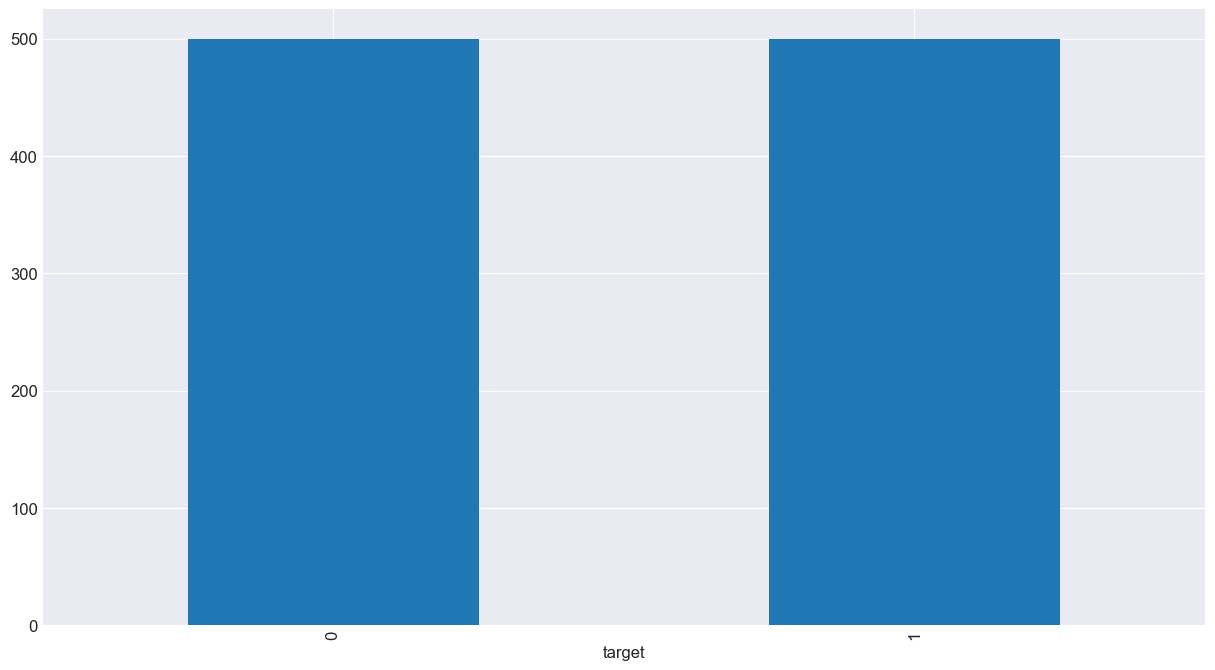

In [10]:
fig, ax = plt.subplots() # Instantiate
    
data_df['target'].value_counts().plot(ax=ax, kind='bar');

### Different ways of plotting data

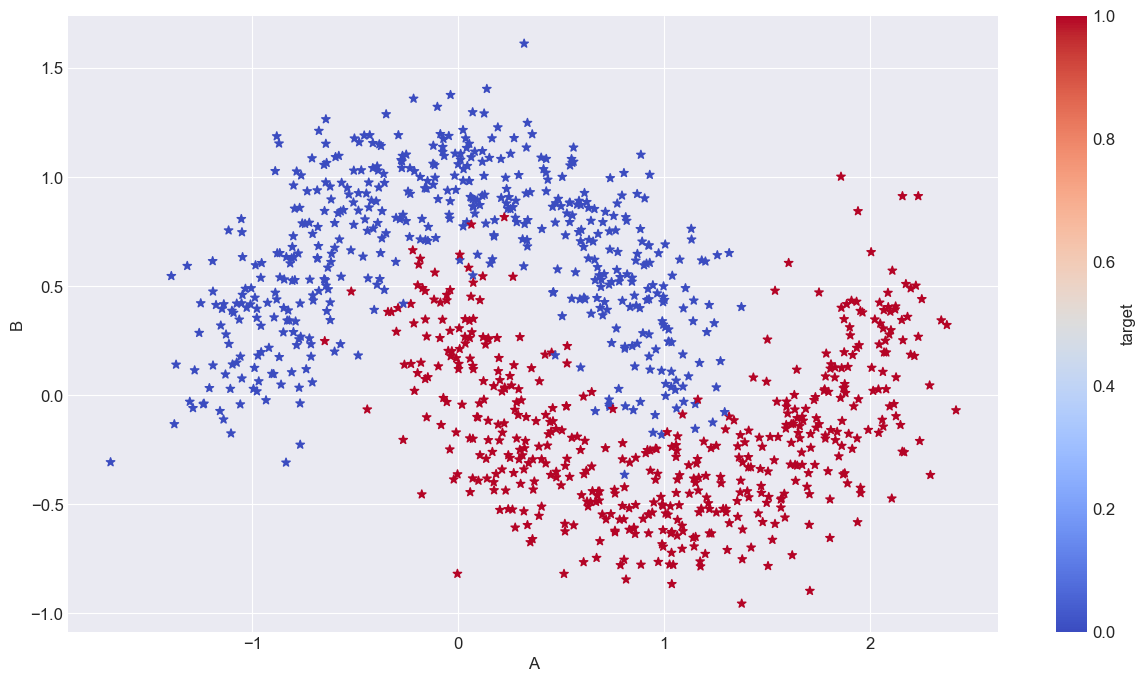

In [11]:
# Plot the data
data_df.plot.scatter('A', 'B',      # columns to plot
                     s = 40,        # size of the marker
                     marker = '*',  # type of marker
                     c = 'target',  # color as per target column
                     cmap=CMAP);    # using colormap

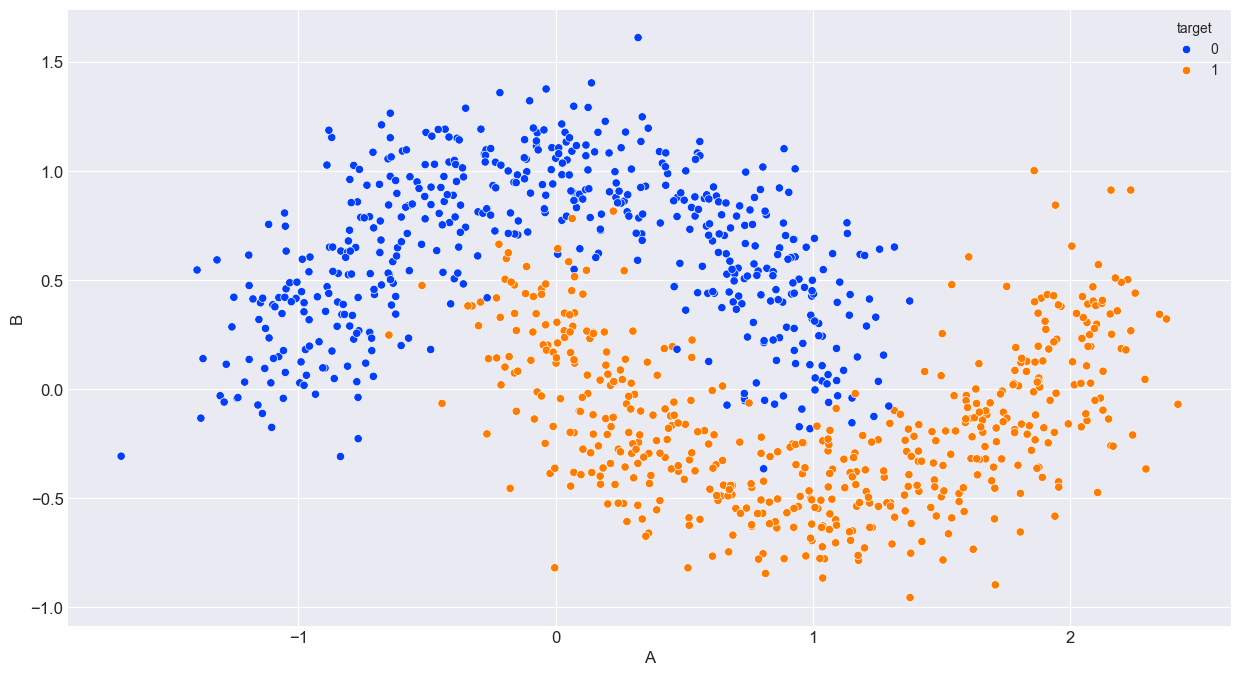

In [12]:
# Using Seaborn
ax = sns.scatterplot(data=data_df, # data from dataframe
                     x='A', y='B',  # X axis and y axis columns
                     palette=sns.color_palette("bright", 2), # color map
                     hue='target'); # Color as per target column

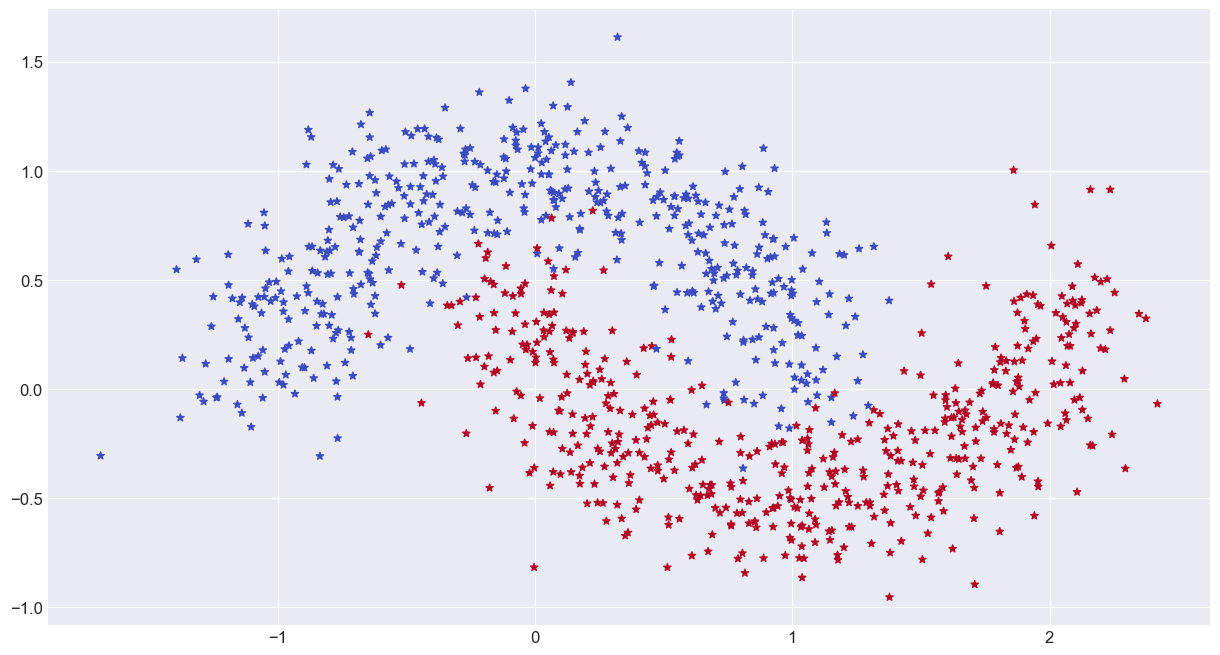

In [13]:
#### In case you want to plot X Array directly
plt.scatter(X[:,0], X[:,1], s=30, c=y, marker = '*', cmap=CMAP);

In [14]:
plt.scatter?

Signature:
plt.scatter(
    x: 'float | ArrayLike',
    y: 'float | ArrayLike',
    s: 'float | ArrayLike | None' = None,
    c: 'ArrayLike | Sequence[ColorType] | ColorType | None' = None,
    marker: 'MarkerType | None' = None,
    cmap: 'str | Colormap | None' = None,
    norm: 'str | Normalize | None' = None,
    vmin: 'float | None' = None,
    vmax: 'float | None' = None,
    alpha: 'float | None' = None,
    linewidths: 'float | Sequence[float] | None' = None,
    *,
    edgecolors: "Literal['face', 'none'] | ColorType | Sequence[ColorType] | None" = None,
    plotnonfinite: 'bool' = False,
    data=None,
    **kwargs,
) -> 'PathCollection'
Docstring:
A scatter plot of *y* vs. *x* with varying marker size and/or color.

Parameters
----------
x, y : float or array-like, shape (n, )
    The data positions.

s : float or array-like, shape (n, ), optional
    The marker size in points**2 (typographic points are 1/72 in.).
    Default is ``rcParams['lines.markersize'] ** 2``.

    Th

In [15]:
data_train, data_test = data_df.to_numpy()[:900], data_df.to_numpy()[900:]

In [16]:
data_train.shape, data_test.shape

((900, 3), (100, 3))

In [17]:
rng.random(data_train.shape[1])

array([0.33026884, 0.40517732, 0.57473782])

Stochastic Gradient Descent

In [18]:
def sigmoid(z):
    return 1 / (1 + (np.exp(-z)))

In [19]:
def predict(row, weights):

    z = weights[0]

    for i in range (len(row) - 1):
        z += weights[i+1] * row[i] # z = (weight * X) + b
    
    return sigmoid(z)

In [20]:
def train_weights(train, n_epochs, alpha):
    errors = []
    weights = rng.random(train.shape[1]) # weights at random

    m = train.shape[0] # no of rows in training data

    for epoch in range(n_epochs):
        sum_error = 0.0

        for row in train:
            prediction = predict(row, weights)

            dz = prediction - row[-1]

            sum_error += row[-1] * np.log(prediction)

            weights[0] = weights[0] - alpha * dz / m

            for i in range(len(row)-1):
                weights[i+1] = weights[i+1] - alpha * dz * row[i] / m
        
        errors.append(sum_error/m)
    
    return errors, weights

In [21]:
errors, weights = train_weights(data_train, EPOCHS, ALPHA)

In [22]:
errors

[-0.17371406896170297,
 -0.17493715453071587,
 -0.17613043356524852,
 -0.17729366900786583,
 -0.1784266799391106,
 -0.17952934070344248,
 -0.18060157975463725,
 -0.18164337824265883,
 -0.18265476836595407,
 -0.18363583151452598,
 -0.1845866962300544,
 -0.18550753600974165,
 -0.18639856698053675,
 -0.1872600454699509,
 -0.1880922654988891,
 -0.18889555622080914,
 -0.1896702793301767,
 -0.19041682646162258,
 -0.19113561659950454,
 -0.1918270935157652,
 -0.19249172325211306,
 -0.19312999166066427,
 -0.19374240201531365,
 -0.1943294727042736,
 -0.1948917350124644,
 -0.19542973100077426,
 -0.19594401148762766,
 -0.1964351341368702,
 -0.19690366165463463,
 -0.19735016009665338,
 -0.19777519728640458,
 -0.19817934134352944,
 -0.1985631593211186,
 -0.1989272159497567,
 -0.19927207248560466,
 -0.19959828565929053,
 -0.19990640672198096,
 -0.20019698058466873,
 -0.2004705450464764,
 -0.20072763010760172,
 -0.2009687573624171,
 -0.20119443946816742,
 -0.20140517968473487,
 -0.20160147148092464,
 

In [23]:
weights

array([-0.21388458,  1.21079479, -1.69764541])

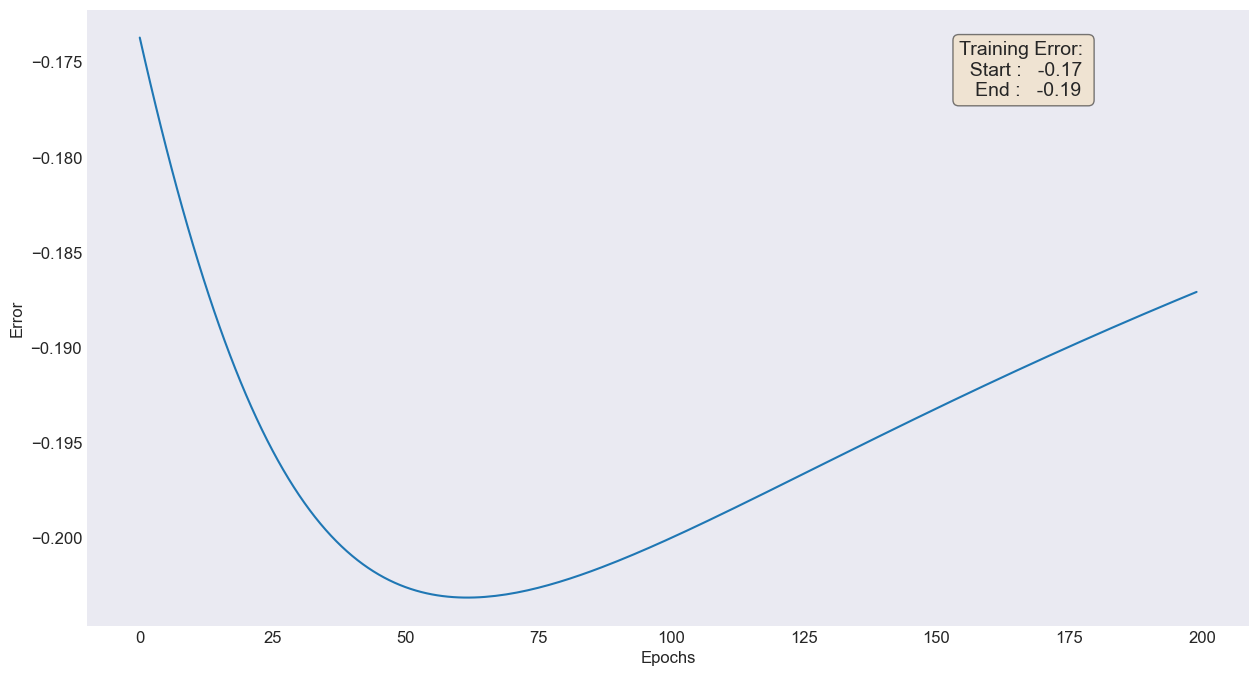

In [24]:
fig, ax = plt.subplots()
ax.plot(errors);

# little beautification
txtstr = "Training Error: \n  Start : {:7.2f}\n   End : {:7.2f}".format(errors[0],errors[-1]) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper right in axes coords
ax.text(0.75, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")

ax.set_ylabel("Error")

ax.grid();

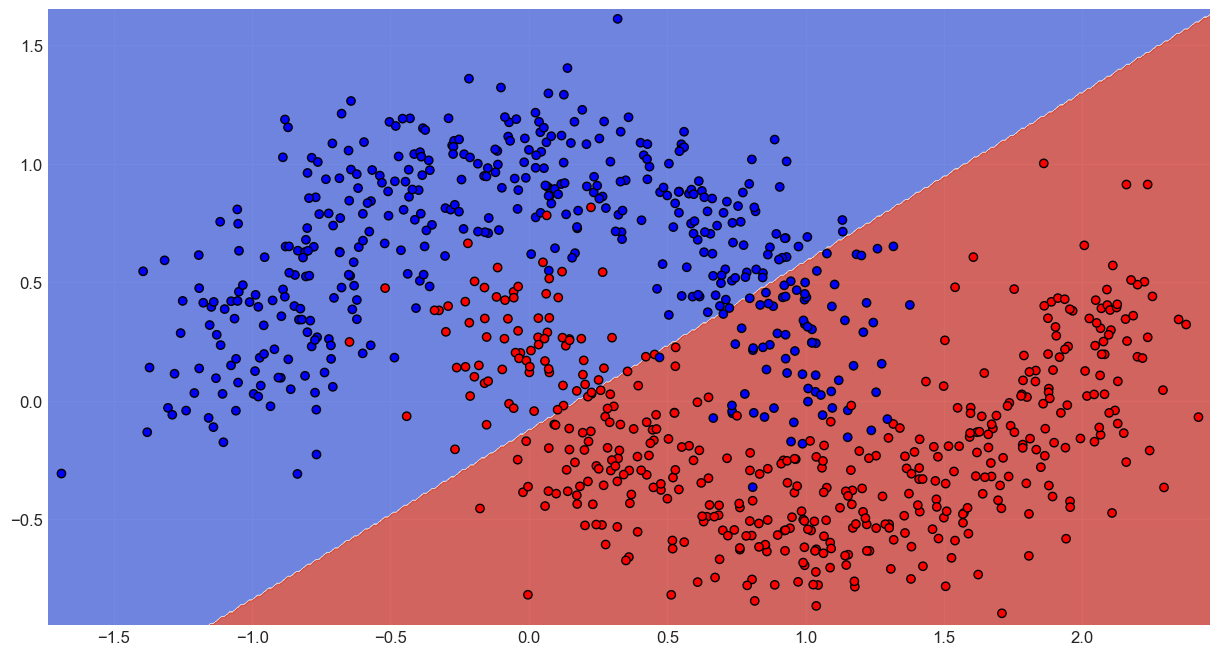

In [25]:
X = data_train

fig, ax = plt.subplots()
dm = 0.01

X_min, X_max = X[:,0].min() - 0.05, X[:,0].max() + 0.05
y_min, y_max = X[:,1].min() - 0.05, X[:,1].max() + 0.05

xx, yy = np.meshgrid(np.arange(X_min, X_max, dm),
                     np.arange(y_min, y_max, dm))

XX = np.c_[xx.ravel(), yy.ravel()]
XX = np.hstack((XX, np.ones((XX.shape[0],1))))

y_pred = []

for row in XX:
    pred = predict(row, weights)
    y_pred.append(np.round(pred)) # to get only 2 sections in the contour, we used np.round(pred)

Z = np.array(y_pred).reshape(xx.shape)

ax.contourf(xx, yy, Z, cmap=CMAP, alpha=0.8)
ax.scatter(X[:,0], X[:,1], c = X[:,2],edgecolors='k', cmap=plt.cm.bwr, marker='o');

In [26]:
xx.shape, yy.shape

((261, 421), (261, 421))

In [27]:
predictions = []

for row in data_train:
    
    a = predict(row, weights)
    
    prediction = 0
    
    if a >= 0.5: prediction = 1 # argmax

    predictions.append(prediction)

In [28]:
accuracy_score(data_train[:,-1], predictions)

0.8288888888888889

In [29]:
predictions = []

for row in data_test:
    
    a = predict(row, weights)
    
    prediction = 0
    
    if a >= 0.5: prediction = 1
    predictions.append(prediction)

accuracy_score(data_test[:,-1], predictions)


0.89

In [30]:
cm = confusion_matrix(data_test[:, -1], predictions)
cm

array([[54,  4],
       [ 7, 35]], dtype=int64)

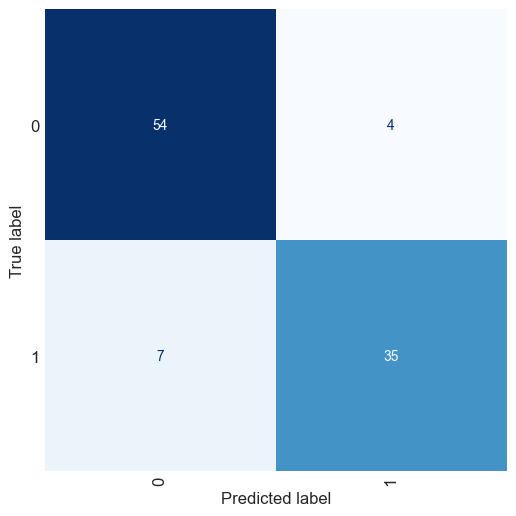

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
fig, ax = plt.subplots(figsize = (6,6))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
# Disable the grid
ax.grid(False)

plt.show();